<a href="https://colab.research.google.com/github/ZenanAH/Team_Energy/blob/master/RNN_on_groups_zen_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras .models import Sequential
from tensorflow.keras .layers import Dense, LSTM, Dropout, GRU, Bidirectional
from tensorflow.keras .optimizers import SGD
import math
from sklearn.metrics import mean_absolute_percentage_error

In [ ]:
#!pip install tensorflow

In [14]:
# Some functions to help out with
def plot_predictions(df_plot):
    plt.figure(figsize=(18,6))
    plt.plot(df_plot)
    plt.title('Electricity Consumption Prediction')
    plt.xlabel('Time')
    plt.ylabel('Consumption (kWh/hh)')
    plt.legend()
    plt.show()

def return_mape(test,predicted):
    mape = mean_absolute_percentage_error(test, predicted)
    print("The  mean absolute percenatge error is {}.".format(mape))

In [24]:
acorn_group="A"
tariff='Std'
dataset = pd.read_csv(f'https://storage.googleapis.com/energy_usage_prediction_903/df_{acorn_group}_avg_{tariff}_v1.csv', index_col='DateTime', parse_dates=['DateTime'])
dataset.head()

,Unnamed: 0,KWH/hh,tariff
DateTime,,,
2012-01-01 00:00:00,0,0.495875,Std
2012-01-01 00:30:00,1,0.506625,Std
2012-01-01 01:00:00,2,0.470625,Std
2012-01-01 01:30:00,3,0.392375,Std
2012-01-01 02:00:00,4,0.477750,Std


In [25]:
df=dataset.groupby(by=dataset.index).mean()
#df.reset_index(inplace=True)
df.drop(columns="Unnamed: 0",inplace=True)
df

,KWH/hh
DateTime,
2012-01-01 00:00:00,0.495875
2012-01-01 00:30:00,0.506625
2012-01-01 01:00:00,0.470625
2012-01-01 01:30:00,0.392375
2012-01-01 02:00:00,0.477750
...,...
2014-02-27 22:00:00,0.598800
2014-02-27 22:30:00,0.571820
2014-02-27 23:00:00,0.511040


In [26]:
# Checking for missing values
training_set = df[:'2013'].loc[:,['KWH/hh']].values
test_set = df['2014':].loc[:,['KWH/hh']].values
training_set

array([[0.495875  ],
       [0.506625  ],
       [0.470625  ],
       ...,
       [0.59709804],
       [0.60901961],
       [0.58235295]])

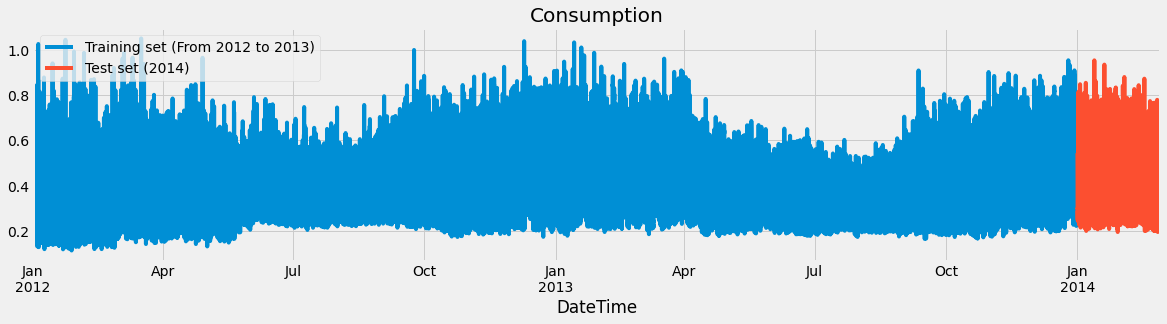

In [28]:
df["KWH/hh"][:'2013'].plot(figsize=(18,4),legend=True)
df["KWH/hh"]['2014':].plot(figsize=(18,4),legend=True)
plt.legend(['Training set (From 2012 to 2013)','Test set (2014)'])
plt.title('Consumption')
plt.show()

In [29]:
# Scaling the training set
sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(training_set)

In [30]:
# Since LSTMs store long term memory state, we create a data structure with 60 timesteps and 1 output
# So for each element of training set, we have 60 previous training set elements 
X_train = []
y_train = []
for i in range(60,len(training_set_scaled)):
    X_train.append(training_set_scaled[i-60:i,0])
    y_train.append(training_set_scaled[i,0])
X_train, y_train = np.array(X_train), np.array(y_train)

In [31]:
# Reshaping X_train for efficient modelling
X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))

In [32]:
# The LSTM architecture
regressor = Sequential()
# First LSTM layer with Dropout regularisation
regressor.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
regressor.add(Dropout(0.2))
# Second LSTM layer
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))
# Third LSTM layer
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))
# Fourth LSTM layer
regressor.add(LSTM(units=50))
regressor.add(Dropout(0.2))
# The output layer
regressor.add(Dense(units=1))

# Compiling the RNN
regressor.compile(optimizer='rmsprop',loss='MeanAbsolutePercentageError')
# Fitting to the training set
regressor.fit(X_train,y_train,epochs=50,batch_size=32)

Epoch 1/50
1095/1095 [==============================] - 23s 16ms/step - loss: 2766.4146
Epoch 2/50
1095/1095 [==============================] - 17s 15ms/step - loss: 1741.2034
Epoch 3/50
1095/1095 [==============================] - 17s 15ms/step - loss: 1979.0044
Epoch 4/50
1095/1095 [==============================] - 16s 15ms/step - loss: 1667.3739
Epoch 5/50
1095/1095 [==============================] - 17s 15ms/step - loss: 2046.6986
Epoch 6/50
1095/1095 [==============================] - 17s 16ms/step - loss: 1801.2698
Epoch 7/50
1095/1095 [==============================] - 18s 17ms/step - loss: 1108.0540
Epoch 8/50
1095/1095 [==============================] - 18s 17ms/step - loss: 2917.9766
Epoch 9/50
1095/1095 [==============================] - 18s 17ms/step - loss: 1666.6432
Epoch 10/50
1095/1095 [==============================] - 18s 17ms/step - loss: 1861.3662
Epoch 11/50
1095/1095 [==============================] - 17s 16ms/step - loss: 1199.1217
Epoch 12/50
1095/1095 [=======

In [33]:
# Now to get the test set ready in a similar way as the training set.
# The following has been done so first 60 entries of test set have 60 previous values which is impossible to get 

dataset_total = pd.concat((df["KWH/hh"][:'2013'],df["KWH/hh"]['2014':]),axis=0)
inputs = dataset_total[len(dataset_total)-len(test_set) - 60:].values
inputs = inputs.reshape(-1,1)
inputs  = sc.transform(inputs)

In [34]:
# Preparing X_test and predicting the prices
X_test = []
for i in range(60,len(inputs)):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
predicted_consumption = regressor.predict(X_test)
predicted_consumption = sc.inverse_transform(predicted_consumption)

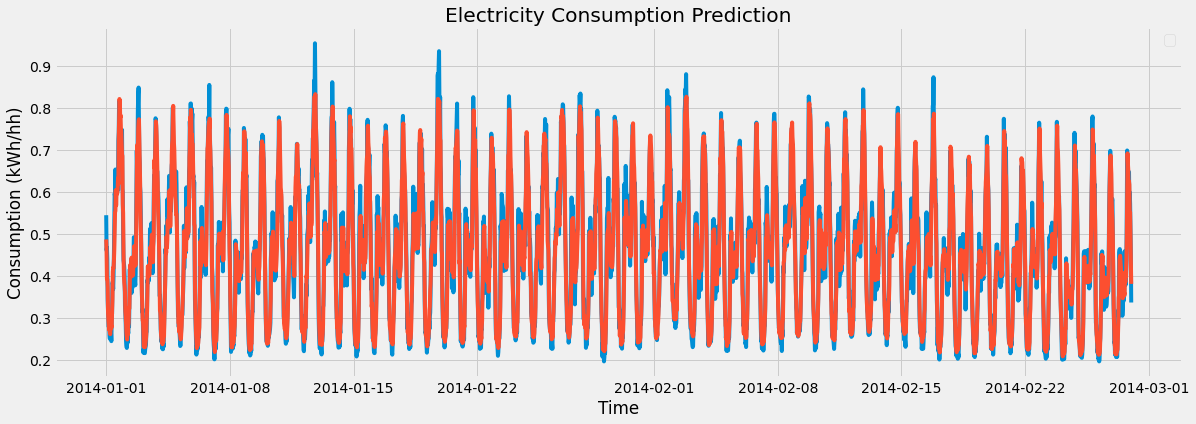

The  mean absolute percenatge error is 0.06644543720193269.


In [35]:

# Visualizing the results for LSTM
df_plot=df['2014':].copy()
df_plot.rename(columns={'KWH/hh':'Test'},inplace=True)
df_plot['Predicted']=predicted_consumption
plot_predictions(df_plot)
# Evaluating our model
return_mape(test_set,predicted_consumption)